In [2]:
from dataclasses import dataclass, field
from typing import List, Dict

import numpy as np
import matplotlib.pyplot as plt

import blackjack

In [3]:
%matplotlib inline
np.random.seed(0)

In [4]:
@dataclass
class State:
    hand_total: int
    dealer_total: int
    
    def __hash__(self) -> int:
        return hash((self.hand_total, self.dealer_total))

In [5]:
@dataclass
class QTable:
    q_table: Dict[State, List[float]] = field(default_factory=dict)
    possible_player_totals: np.ndarray = field(init=False)
    possible_dealer_totals: np.ndarray = field(init=False)
    
    def __post_init__(self) -> None:
        self.possible_player_totals = np.arange(2, 22)
        self.possible_dealer_totals = np.arange(1, 12)
        
        for hand_total in self.possible_player_totals:
            for dealer_total in self.possible_dealer_totals:
                self.q_table[State(hand_total, dealer_total)] = np.random.uniform(size=(2))
        
    
    def __getitem__(self, state: State) -> List[float]:
        if state.hand_total > 21:
            return [-2]
        return self.q_table[state]
    
    def __setitem__(self, state: State, value: List[float]):
        if state.hand_total > 21:
            return
        self.q_table[state] = value
        
    def policy(self, state: State) -> int:
        if state.hand_total >= 21:
            return 0
        return np.argmax(self[state])
    
    def display_policy(self) -> None:
        policy = np.zeros((self.possible_player_totals.shape[0], self.possible_dealer_totals.shape[0]))
        for state in self.q_table:
            policy[state.hand_total - 2, state.dealer_total - 1] = self.policy(state)
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(policy, cmap=plt.cm.RdYlGn)
        
        
        ax.set_xticks(np.arange(len(self.possible_dealer_totals)))
        ax.set_yticks(np.arange(len(self.possible_player_totals)))
        
        ax.set_xticklabels(self.possible_dealer_totals)
        ax.set_yticklabels(self.possible_player_totals)
        
        ax.set_ylabel('Player Total')
        ax.set_xlabel('Dealer Total')
        
        return fig
        
        

In [60]:
class Agent:
    def __init__(self, learning_rate: float = 0.1, discount_factor: float = 0.9, epsilon_greedy: float = 0.1, training_epochs: int = 1000, benchmark_epochs: int = 1000) -> None:
        
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon_greedy = epsilon_greedy
        
        self.training_epochs = training_epochs
        self.benchmark_epochs = benchmark_epochs
        self.log_frequency = training_epochs // 10
        
        self.current_epoch = 0
        
        self.q_table = QTable()
        
        self.deck = blackjack.Deck()
        self.dealer = blackjack.Dealer()
        self.player = blackjack.Player()    
        
        self.state = State(0, 0)
        
    def action(self, state: State, use_epsilon_greedy: bool = True) -> int:
        if np.random.random() < self.epsilon_greedy and use_epsilon_greedy:
            return np.random.choice([0, 1])
        else:
            return self.q_table.policy(state)
    
    def reward(self, player_total: int, dealer_total: int) -> int:
        if player_total > 21:
            return -1
        elif player_total == dealer_total:
            return 0
        elif dealer_total > 21:
            return 1
        elif player_total > dealer_total:
            return 1
        else:
            return -1
    
    def start_turn(self) -> None:
        self.deck.reset()
        self.player.clear_hand()
        self.player.playing = True
        self.player.actions_taken = []
        
        self.dealer.clear_hand()
        
        self.player.hit(self.deck, save_action=False)
        self.player.hit(self.deck, save_action=False)
        self.dealer.hit(self.deck)
        self.dealer.hit(self.deck)
        
    def play(self, use_epsilon_greedy: bool = True) -> int:
        self.start_turn()
        self.dealer.play(self.deck)
        self.state = State(hand_total=self.player.hand.total, dealer_total=self.dealer.partial_total)
        
        if not self.player.playing: # blackjack hit
            self.player.actions_taken.append({
                "action": 0,
                "total": self.player.hand.total,
                "usable_ace": self.player.hand.usable_ace,
                "new_total": self.player.hand.total,
                "reward": 0
            })
        
        while self.player.playing:
            action = self.action(self.state, use_epsilon_greedy=use_epsilon_greedy)
            self.player.play(action=action, deck=self.deck)
            self.state.hand_total = self.player.hand.total

        reward = self.reward(self.player.hand.total, self.dealer.hand.total)
        
        for action in self.player.actions_taken:
            action["reward"] = reward
            
        return reward
    
    
    def learn(self) -> None:
        for action in self.player.actions_taken:
            action_state = State(action["total"], self.dealer.partial_total)
            new_state = State(action["new_total"], self.dealer.partial_total)
            self.q_table[action_state][action["action"]] = (1 - self.learning_rate) * self.q_table[action_state][action["action"]] + self.learning_rate * (action["reward"] + self.discount_factor * np.max(self.q_table[new_state]))    
    
    def train(self) -> None:
        for _ in range(self.current_epoch, self.training_epochs + self.current_epoch):
            self.current_epoch += 1            
            if self.current_epoch % self.log_frequency == 0:
                print(f"Epoch {self.current_epoch}")
                self.benchmark()
            self.play(use_epsilon_greedy=True)
            self.learn()
    
    
    def benchmark(self) -> None:
        hands_won = 0
        hands_played = 0
        
        for _ in range(self.benchmark_epochs):
            if self.play(use_epsilon_greedy=False) == 1:
                hands_won += 1
            hands_played += 1
        print(f"Hands won: {hands_won} / {hands_played} ({hands_won / hands_played * 100:.2f}%)")
        
        
        

        
        
        

In [63]:
agent = Agent(
    learning_rate=0.1,
    discount_factor=0.9,
    epsilon_greedy=0.1,
    training_epochs=10000,
    benchmark_epochs=1000
)

In [ ]:
for _ in range(80):
    agent.train()

Hands won: 4025 / 10000 (40.25%)


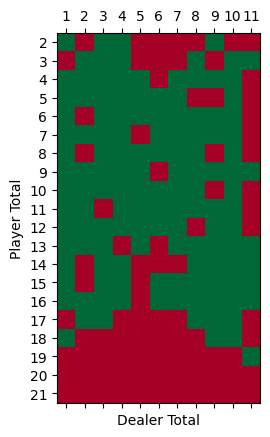

In [59]:
agent.benchmark()